# Урок 6. Градиентный бустинг

In [66]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [67]:
from sklearn.datasets import load_diabetes

In [68]:
X, y = load_diabetes(return_X_y=True)

In [69]:
X.shape

(442, 10)

In [70]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [71]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [72]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [73]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [74]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [75]:
%%time
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 1.94 s


In [76]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [77]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2670.4331516223283
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 9421.260837626876


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [78]:
import matplotlib.pyplot as plt

In [79]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

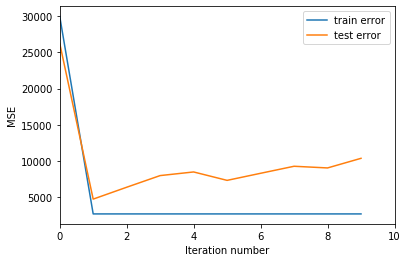

In [80]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [81]:
%%time
n_trees = 100
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 3min 19s


In [82]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2670.433151622327
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 9782.666533101587


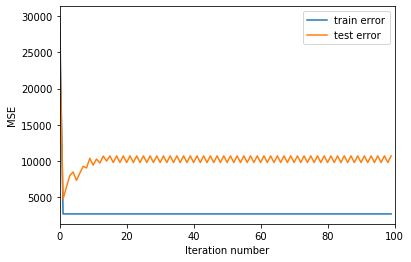

In [83]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [84]:
%%time
eta = 0.1
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 48.4 s


In [85]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 801.3822586173845
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 4354.307352711463


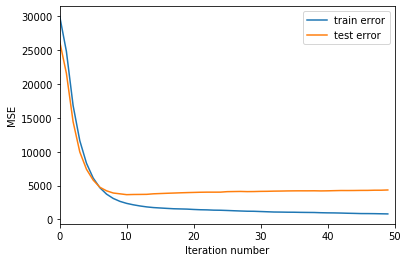

In [86]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [87]:
%%time
eta = 0.01
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 49.9 s


In [88]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 6050.72982511483
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 5755.973576973062


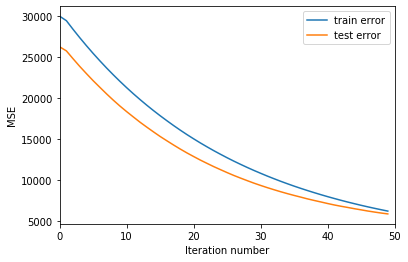

In [89]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [90]:
%%time
eta = 0.1
max_depth = 100
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 53 s


In [91]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 100     с шагом 0.1 на тренировочной выборке: 7.746405543265178e-06
Ошибка алгоритма из 50 деревьев глубиной 100     с шагом 0.1 на тестовой выборке: 7422.607717578999


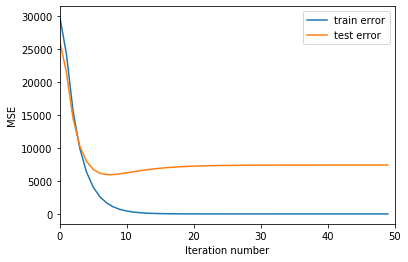

In [92]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [94]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [95]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [96]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [97]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [98]:
N = 100
models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [99]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [100]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 98.122
Точность алгоритма на тестовой выборке: 93.706


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

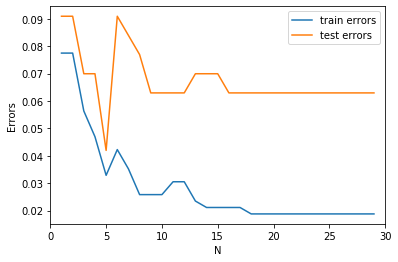

In [101]:
train_errors = []
test_errors = []

for n in range(1, 30):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
    
x = list(range(1, 30))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right');

## Дополнительные материалы

1. [Лекция Радослава Нейчева на тему ансамблей](https://www.youtube.com/watch?v=md5krGNRrwU&list=PL4_hYwCyhAvasRqzz4w562ce0esEwS0Mt&index=8&t=10s)
2. [Интерактивная визуализация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

### Домашнее задание:  
1. Для реализованной модели (gb_fit) построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  
2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

### Задача 1

Реализуем прогноз данных для 10 деревьев в ансамбле

In [102]:
train_errors_10 = []
test_errors_10 = []
coefs_10 = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 10):
    trees_10, train_errors_10, test_errors_10 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs_10, eta)
    train_prediction_10 = gb_predict(X_train, trees_10, coefs_10, eta)
    test_prediction_10 = gb_predict(X_test, trees_10, coefs_10, eta)
    train_errors_10.append(mean_squared_error(y_train, train_prediction_10))
    test_errors_10.append(mean_squared_error(y_test, test_prediction_10))

No handles with labels found to put in legend.


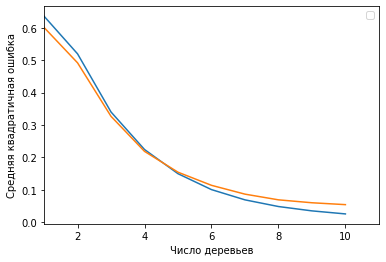

In [103]:
x = list(range(1, 11))

plt.xlim(1, 11)
plt.plot(x, train_errors_10)
plt.plot(x, test_errors_10)
plt.xlabel('Число деревьев')
plt.ylabel('Средняя квадратичная ошибка')
plt.legend(loc='upper right')
plt.show()

Реализуем прогноз данных для 20 деревьев в ансамбле

In [104]:
train_errors_20 = []
test_errors_20 = []
coefs_20 = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 20):
    trees_20, train_errors_20, test_errors_20 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs_20, eta)
    train_prediction_20 = gb_predict(X_train, trees_20, coefs_20, eta)
    test_prediction_20 = gb_predict(X_test, trees_20, coefs_20, eta)
    train_errors_20.append(mean_squared_error(y_train, train_prediction_20))
    test_errors_20.append(mean_squared_error(y_test, test_prediction_20))

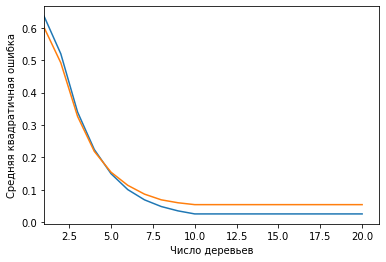

In [105]:
x = list(range(1, 21))

plt.xlim(1, 21)
plt.plot(x, train_errors_20)
plt.plot(x, test_errors_20)
plt.xlabel('Число деревьев')
plt.ylabel('Средняя квадратичная ошибка')
plt.show()

Реализуем прогноз данных для 50 деревьев в ансамбле

In [106]:
train_errors_50 = []
test_errors_50 = []
coefs_50 = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 50):
    trees_50, train_errors_50, test_errors_50 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs_50, eta)
    train_prediction_50 = gb_predict(X_train, trees_50, coefs_50, eta)
    test_prediction_50 = gb_predict(X_test, trees_50, coefs_50, eta)
    train_errors_50.append(mean_squared_error(y_train, train_prediction_50))
    test_errors_50.append(mean_squared_error(y_test, test_prediction_50))

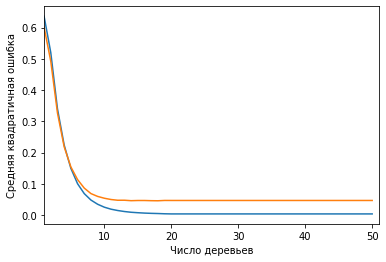

In [107]:
x = list(range(1, 51))

plt.xlim(1, 51)
plt.plot(x, train_errors_50)
plt.plot(x, test_errors_50)
plt.xlabel('Число деревьев')
plt.ylabel('Средняя квадратичная ошибка')
plt.show()

<b>Вывод</b>: при числе деревьев, равное 20 средняя квадратичная ошибка минимальна

### Задача 2

Определим функцию стохастического бустинга

In [112]:
def stochastic_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, rand_sample_size=0.5):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Случайно выбираем часть индексов
            list_shape = list(range(X_train.shape[0]))
            train_choice = np.random.choice(list_shape, size=int(rand_sample_size*len(list_shape)))
            
            # Получаем прогноз на элементах из выбранных индексов
            pred_choice = gb_predict(X_train[train_choice], trees, coefs, eta)
            
            # Обучаем дерево по полученному прогнозу
            tree.fit(X_train[train_choice], deriv(y_train[train_choice], pred_choice))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [113]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 3
eta = 0.2

trees, train_errors_s, test_errors_s = stochastic_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [114]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

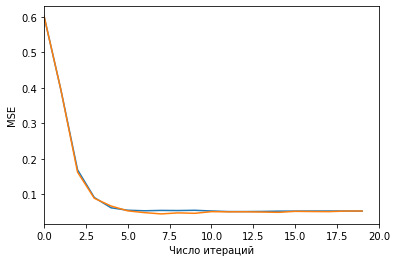

In [116]:
plt.xlabel('Число итераций')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label='обычный бустинг')
plt.plot(list(range(n_trees)), test_errors_s, label='стохастический бустинг')
plt.show();

<b>Вывод</b>: при исользовании стохастического бустинга наблюдается просадка средней квадратичной ошибки, когда у обычного имеется стабилизация